# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

  4.2 Create Token-Integer Mappings

  4.3 Split Data into Train and Validation Sets

  4.4 Pad Sequences

  4.5 Convert Text Sequences to Integer Sequences</br>
  4.6 Implement GloVe Embeddings
5. Model Building

  5.1 Define Model Architecture
  
  5.2 Start Model Training
6. Text Generation
7. Test Model

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras import backend as K 
K.clear_session()

In [2]:
# reproducing same results
SEED = 2019

np.random.rand(SEED)

array([0.67956432, 0.70609602, 0.89349849, ..., 0.79606331, 0.75821261,
       0.83340368])

# 2. Load Dataset

In [3]:
# open text file and read in data
with open("Dailog-dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [4]:
# number of text sequences
len(dialogs)

64776

In [5]:
dialogs = list(set(dialogs))

In [6]:
# print 10 random dialogs
random.sample(dialogs, 10)

[' You can charge that to my card',
 'Im in Boise, ID at the Red Lion Hotel',
 'dinner for seven tonight at a restaurant',
 'My check engine light keeps coming on and the temperature seems to be overheating',
 "Ok, I'll see if they have a large dining table with outside seating available then",
 'That works, Linda lives in West Covina so that’s close',
 'Thank you too!',
 'Nope, that is all',
 'Yes, with an extra shot of espresso, almond milk, and sugar free syrup',
 'I cannot shut my roof']

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [7]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)


## 3.2 Finding Word Count

In [8]:
# get list of all the words
all_words = " ".join(dialogs_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1

In [9]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [10]:
# vocabulary size
len(words_df)

11147

In [11]:
words_df.head()

,word,count
0,unbelievable,1
1,oleys,1
2,largethen,1
3,sorted,1
4,rangeline,1


In [12]:
words_df.tail()

,word,count
11142,you,9544
11143,a,12512
11144,to,13307
11145,the,14704
11146,i,18419


## 3.3 Find and Replace Rare Words with "Unknown" Token

In [13]:
# user specified threshold value
rare_thresh = 2

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [14]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 48.41
Rare words coverage in the corpus: 1.25


In [15]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

Replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [16]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [17]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [18]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [19]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
#for d in tqdm_notebook(dialogs_clean):
for d in dialogs_clean:
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

In [20]:
dialogs_clean_v2 = dialogs_clean#_v2[:50000]

In [21]:
dialogs_clean_v2[:10]

['okay let me tell you the problem',
 'lets go with the original uber',
 ' can i get an appointment into intelligent solutions',
 ' and add some green bell peppers on there too',
 'can you have them sent to my cell',
 "i think we just want a booth it's going to be too cold on sunday",
 " you're a lifesaver",
 "hello i'm looking for a table for two tonight at a mexican restaurant",
 'book me a reservation at zelos with the same info',
 'i would like almond milk please']

# 4. Data Preparation

## 4.1 Prepare Sequences

54832


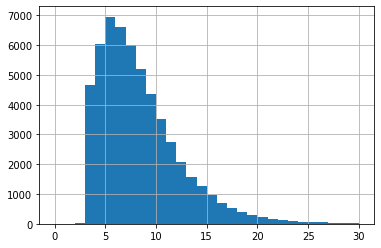

In [22]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))
print(len(text_word_count))

In [23]:
# function to create sequences of equal length
def create_seq1(text, seq_len = 5):
      
  sequences = []    
  temp = 0
  seq_len1 = 5
  if len(text.split()) > seq_len:
    for i in range(0, round(len(text.split())/seq_len)):
      # select sequence of tokens
      seq = text.split()[temp:seq_len1]
      temp = seq_len1
      seq_len1 = seq_len + temp
      
      if len(seq) > 0:
        # append sequence to the list
        sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [24]:
# function to create sequences of equal length
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [25]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2 if len(i) < 100 and len(i) > 1]
#seqs = [i for i in dialogs_clean_v2 if len(i) < 80]
seqs[:10]

[['okay let me tell you the', 'let me tell you the problem'],
 ['lets go with the original uber'],
 ['can i get an appointment into',
  'i get an appointment into intelligent',
  'get an appointment into intelligent solutions'],
 ['and add some green bell peppers',
  'add some green bell peppers on',
  'some green bell peppers on there',
  'green bell peppers on there too'],
 ['can you have them sent to',
  'you have them sent to my',
  'have them sent to my cell'],
 ['i think we just want a',
  'think we just want a booth',
  "we just want a booth it's",
  "just want a booth it's going",
  "want a booth it's going to",
  "a booth it's going to be",
  "booth it's going to be too",
  "it's going to be too cold",
  'going to be too cold on',
  'to be too cold on sunday'],
 [" you're a lifesaver"],
 ["hello i'm looking for a table",
  "i'm looking for a table for",
  'looking for a table for two',
  'for a table for two tonight',
  'a table for two tonight at',
  'table for two tonight at

In [26]:
# merge list-of-lists into a single list
corpus = sum(seqs, [])


In [27]:
corpus[:20]

['okay let me tell you the',
 'let me tell you the problem',
 'lets go with the original uber',
 'can i get an appointment into',
 'i get an appointment into intelligent',
 'get an appointment into intelligent solutions',
 'and add some green bell peppers',
 'add some green bell peppers on',
 'some green bell peppers on there',
 'green bell peppers on there too',
 'can you have them sent to',
 'you have them sent to my',
 'have them sent to my cell',
 'i think we just want a',
 'think we just want a booth',
 "we just want a booth it's",
 "just want a booth it's going",
 "want a booth it's going to",
 "a booth it's going to be",
 "booth it's going to be too"]

 **4.2 Create Token-Integer Mappings**

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [29]:
total_words

10797

**4.3 Generates a list of n-gram sequences and list of n-gram sequences**

In [30]:
#Create n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    output_sequences = []
    ### START CODE HERE
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      
      for i in range(2, len(token_list)):
        n_gram_seqs= token_list[:i]
        #print(n_gram_seqs)
        input_sequences.append(n_gram_seqs)
        output_sequences.append(token_list[i:i+1][0])
        
    ### END CODE HERE
    
    return input_sequences, output_sequences

In [31]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences, output_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences length: {len(input_sequences)}")
print(f"maximum length of sequences : {max_sequence_len}")
input_sequences[:10]

n_grams of input_sequences length: 676483
maximum length of sequences : 5


[[105, 134],
 [105, 134, 8],
 [105, 134, 8, 129],
 [105, 134, 8, 129, 5],
 [134, 8],
 [134, 8, 129],
 [134, 8, 129, 5],
 [134, 8, 129, 5, 2],
 [256, 36],
 [256, 36, 18]]

In [32]:
output_sequences[:10]

[8, 129, 5, 2, 129, 5, 2, 346, 18, 2]

**4.4 Create Token-Integer Mappings**

In [33]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to same length
    
    Args:
        input_sequences: tokenized sequences to pad
        maxlen: maximum length of sequences
    
    Returns:
        padded_sequences: tokenized sequences padded to  same length
    """

    post_pad_sequence = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')
    return post_pad_sequence

In [34]:
# Pad the whole corpus
pad_sequence = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {pad_sequence.shape}")

padded corpus has shape: (676483, 5)


In [35]:
pad_sequence

array([[   0,    0,    0,  105,  134],
       [   0,    0,  105,  134,    8],
       [   0,  105,  134,    8,  129],
       ...,
       [   0,    0,   13,   15, 2862],
       [   0,   13,   15, 2862,    1],
       [  13,   15, 2862,    1,   17]], dtype=int32)

In [36]:
def features_and_labels(pad_sequence, labels, total_words):

    #features = pre_pad_sequence[:,:-1]
    #one_hot_labels = to_categorical(labels, num_classes=total_words)

    return pad_sequence, np.array(labels)

In [37]:
# Split the whole corpus
features, labels = features_and_labels(pad_sequence, output_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")


features have shape: (676483, 5)
labels have shape: (676483,)


In [38]:
post_pad_sequence = []
pre_pad_sequence = []
seqs = []
#corpus = []
features

array([[   0,    0,    0,  105,  134],
       [   0,    0,  105,  134,    8],
       [   0,  105,  134,    8,  129],
       ...,
       [   0,    0,   13,   15, 2862],
       [   0,   13,   15, 2862,    1],
       [  13,   15, 2862,    1,   17]], dtype=int32)

# **Implement Glove to get better accuracy**

In [39]:
# Define path to file containing the embeddings
GLOVE_FILE = './glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, 'r', errors = 'ignore', encoding='utf8') as f:
    for line in f:
        values = line.split()
        values = ['0' if x=='.' else x for x in values]
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

f.close()

In [40]:
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
# Initialize empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((total_words+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# **5.1 Define Model Architecture**

In [41]:
from keras import regularizers
from keras.regularizers import l2
def create_model(total_words, embedding_dim, embeddings_matrix,  max_sequence_len):
  model = Sequential()
  #model.add(Embedding(total_words, 100, input_length=max_sequence_len))

  model.add(Embedding(total_words+1, embedding_dim, input_length=max_sequence_len, weights=[embeddings_matrix]))
  #model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.15 , dropout = 0.15))
  #model.add(tf.keras.layers.Dropout(.2))
  model.add(Bidirectional(LSTM(units=128)))

  model.add(Dense(total_words, activation='softmax'))
  learning_rate = 0.001
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer= opt,
                metrics=['accuracy'])

  model.summary()
  return model

 **5.2 Train Model**

In [44]:
# Get the untrained model
epochs=50
model = create_model(total_words, EMBEDDING_DIM, EMBEDDINGS_MATRIX, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=100, verbose=2, batch_size = 512)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 100)            1079800   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 10797)             2774829   
                                                                 
Total params: 4,089,125
Trainable params: 4,089,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1322/1322 - 23s - loss: 4.8951 - accuracy: 0.1781 - 23s/epoch - 17ms/step
Epoch 2/100
1322/1322 - 18s - loss: 3.7308 - accuracy: 0.2900 - 18s/epoch - 14ms/step
Epoch 3/100
1322/1322 - 18s - loss: 3.3065 - accuracy: 0.3280 - 18s/epoc

# **6 Accuracy and Loss curves of trainned model**

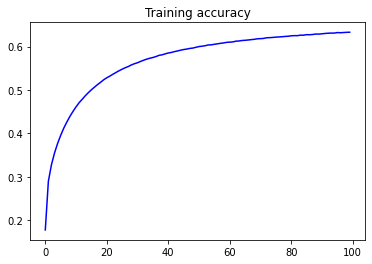

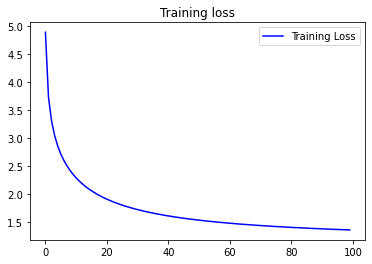

In [45]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Final Results**: Getting 0.6585 accuracy with GLOVE EMBEDDINGS and predicting perfectly on random datasets.

# **Download model**

In [46]:
#with open('tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

FileNotFoundError: ignored

In [47]:
model.save('NextWord_Generation_EDA.h5')

In [48]:
#model = tf.keras.models.load_model("NextWord_Generation_EDA.h5")

# **Test model with new sentence**

In [49]:

def pred(seed_text, output_list_number): 
	next_words = 2
	seed_list = [seed_text] * output_list_number

	for i,s in enumerate(seed_list):
		for _ in range(next_words):
			#print(-i-1)
			# Convert the text into sequences
			token_list = tokenizer.texts_to_sequences([seed_list[i]])[0]
			
			# Pad the sequences
			token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
			
			# Get the probabilities of predicting a word
			predicted = model.predict(token_list, verbose=0)
			predicted1 = np.argmax(predicted, axis=-1).item()
			print(predicted1)
			# Choose the next word based on the maximum probability
			indices = np.argsort(predicted[0], axis=0)[-i-1]
			print(indices)
			# Get the actual word from the word index
			output_word = tokenizer.index_word[indices]
			seed_list[i] = seed_list[i] + " " + output_word
			print(seed_list)
	return seed_list


In [50]:
seeds = ["I would like to order"]
seeds_out = {} 
# number of tokens to generate
num_toks = 3

# text generation
for i,s in enumerate(seeds):
    seeds_out[i] = pred(seeds[i], 2)
    

print(seeds_out)

3
3
['I would like to order a', 'I would like to order']
25
25
['I would like to order a pizza', 'I would like to order']
3
49
['I would like to order a pizza', 'I would like to order some']
25
72
['I would like to order a pizza', 'I would like to order some coffee']
{0: ['I would like to order a pizza', 'I would like to order some coffee']}


In [51]:

model.save('NextWord_Generation_EDA_tokenizer.h5')

# **Sample Test Data**

In [52]:
dialogs[50:65]

['Wow! thats a good price',
 'I will thanks',
 "No problem, I'm just going to postpone and reschedule but I have to discuss it with them first",
 'We are at the North Charleston Performing Arts Center and want to go to the Vendue rooftop bar',
 'A caffe americano',
 'Great, thanks for that',
 'Send me the receipt',
 ' Not the usual',
 'Just two tickets, I am going with a friend',
 'Somewhere that has Thai food',
 'Some ovalini please',
 'In a booth?',
 "Let's do the Pool",
 'I can be ready now, so as soon as possible',
 'nope that will be it']